# Chern insulators and the QWZ model

![kep](./laughlin_v3.png)
In this notebook we are going to explore the QWZ model one of the most simple examples of Chern insuators. We will first explore the spectrum of the bulk and infinite periodic strips of this lattice model, than we generate a finite irregularly shaped system to understand the "potato argument".

In [1]:
# the usual imports
%pylab inline
from ipywidgets import *
from mpl_toolkits.mplot3d import *
#draw a vector
from matplotlib.patches import FancyArrowPatch
# We shall need sparse matrices for the real space structure.. 
# if we want to go for big samples
import scipy.sparse as ssp
import scipy.sparse.linalg  as sla



Populating the interactive namespace from numpy and matplotlib


## Bulk spectrum
The bulk spectrum of the QWZ model is simply given by the magnitude of the $\mathbf{d}(\mathbf{k})$ vector as it goes around the Brillouin zone. We have two bands. At $$E_{\pm}=\pm\sqrt{\sin(k_x)^2+\sin(k_y)^2+(\cos(k_x)+\cos(k_y)+u)^2} .$$

In [2]:
def QWZbulk(u,ee=13,aa=-30):
    '''
    Simple function to generate spectrum
    '''
    xx, yy = meshgrid(linspace(-pi,pi,25),linspace(-pi,pi,25))
    z1 = sqrt(sin(xx)**2+sin(yy)**2+(cos(xx)+cos(yy)+(u))**2)
    # plot the data.. 
    ax0=subplot(111, projection='3d')

    
    props={'linewidth':0,'cmap':'nipy_spectral','antialiased':False,
       'rstride':1, 'cstride':1,'vmin':-z1.max(), 'vmax':z1.max()}

    ax0.plot_surface(xx,yy,z1,**props)
    ax0.plot_surface(xx,yy,-z1,**props)
    
    # everything belo is only for the look
    ax0.view_init(elev=ee, azim=aa)
    ax0.set_aspect(4/pi)

    ax0.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax0.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax0.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax0.set_zlim3d(-4, 4)
    ax0.set_ylim3d(-pi, pi);ax0.set_xlim3d(-pi, pi);
    ax0.grid(False)
    
    lprop={'fontsize':20}
    ax0.set_xlabel(r'$k_x$',**lprop);ax0.set_ylabel(r'$k_y$',**lprop)
    
    ax0.set_xticks(linspace(-pi,pi,3))
    ax0.set_xticklabels([r'-$\pi$',r'$0$',r'$\pi$'],
                    va='baseline',ha='center',**lprop)
    ax0.set_yticks(linspace(-pi,pi,3))
    ax0.set_yticklabels([r'-$\pi$',r'$0$',r'$\pi$'],
                    va='baseline',ha='center',**lprop)
    ax0.set_zticks(linspace(-4,4,5))
    ax0.set_zticklabels([r'$-4$',r'$-2$',r'  $0$',r'  $2$',r'  $4$',],
                    va='baseline',ha='left',**lprop)
    ax0.text(pi+0.6, pi+0.6, 1,r'$E(\mathbf{k})$' ,**lprop);

Depending on the value of $u$ the spectrum can be gapless $u=\pm2$ and $u=0$ or in general gaped

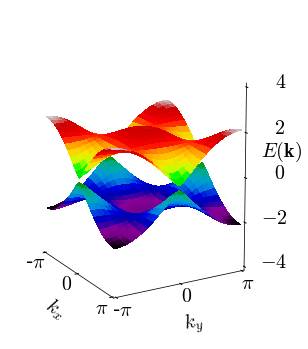

In [3]:
figsize(6,6)
interact(QWZbulk,u=(-2.3,2.3,0.1),ee=fixed(13),aa=fixed(-30));

## Ribbons

Since the Chern number of the QWZ model is nonzero for $|u|<2$ we expect edge states to show up in this intervall.
We write a simple class below that generates data and figures for a translationally invariant ribbon with arbitrary hoppings and onsite terms. We than look at the specific case of the QWZ model at $u=-1.0$.

In [4]:
class ribbon:
    '''
    A class that holds information about a generic translationally inveriant ribbon.
    '''
    def __init__(self,Tx,Ty,U,L=10,kran=linspace(-pi,pi,314),**kwargs):
        '''
        Initialization
        '''
        self.L=L
        self.Tx=Tx
        self.Ty=Ty
        self.U=U
        self.kran=kran
        self.idf=Tx.shape[0]
        
    def build_kham(self,k,**kwargs):
        '''
        Build kspace Hamiltonian
        '''
        idL=matrix(eye(self.L))            # identity matrix of dimension L
        odL=matrix(diag(ones(self.L-1),1)) # upper off diagonal matrix with ones of size L
            
        H=(kron(idL,self.U)+
           kron(odL,self.Tx)+
           kron(odL,self.Tx).H+
           kron(idL,self.Ty)*exp(1.0j*k)+
           kron(idL,self.Ty).H*exp(-1.0j*k))
           
        return H
    
    def spectrdata(self,numLoc=2,norm_treshold=0.6,**kwargs):
        '''
        Get data to be plotted.
        '''
        self.dat=[]             # We will collect the data to be
        self.vecdat=[]          # plotted in these arrays.
        self.lefty=[]
        self.righty=[]
        for k in self.kran:
            H=self.build_kham(k)
            eigdat=eigh(H);       # for a given ky here we calculate the eigensystem (values and vectors)
            # finding and classifying edgestates
            for i in range(self.idf*self.L):
                    if sum(reshape(abs(array(eigdat[1][:,i]))**2,(self.L,self.idf))[:numLoc,:])>norm_treshold:
                        self.lefty=append(self.lefty,[[k,eigdat[0][i]]]);
                    if sum(reshape(abs(array(eigdat[1][:,i]))**2,(self.L,self.idf))[-numLoc:,:])>norm_treshold:
                        self.righty=append(self.righty,[[k,eigdat[0][i]]]);

            self.dat=append(self.dat,eigdat[0]);
            self.vecdat=append(self.vecdat,eigdat[1]);
    
        self.dat=reshape(self.dat,[len(self.kran),2*self.L]);          # rewraping the data
        self.vecdat=reshape(self.vecdat,[len(self.kran),2*self.L,2*self.L]) # to be more digestable
        
    def plotenpsi(self,ki,n,**kwargs):
        '''
        Plot spectrum and charge density of a state.
        '''
        #figsize(14,5)
        subplot(121)
        lcol='#53a4d7'
        rcol='#d7191c'
        # Plotting the eigenvalues and 
        # a marker showing for which state 
        # we are exploring the wavefunction
        plot(self.kran,self.dat,'k-');            
        (lambda x:plot(x[:,0],x[:,1],'o',mec=lcol,mfc=lcol,
                   markersize=10))(reshape(self.lefty,(self.lefty.size/2,2)))
        (lambda x:plot(x[:,0],x[:,1],'o',mec=rcol,mfc=rcol,
                   markersize=10))(reshape(self.righty,(self.righty.size/2,2)))
        plot(self.kran[ki],self.dat[ki,n],'o',markersize=13,mec='k',mfc='w')
    
        # Make it look like the book    
        xlabel(r'wavenumber $k$',fontsize=25);        
        xticks(linspace(-pi,pi,5),[r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'],fontsize=25)
        ylabel(r'energy $E$',fontsize=25);
        yticks(fontsize=25)
        ylim(-2.99,2.99)
        xlim(-pi,pi)
        grid()

        subplot(122)
        # Plotting the sublattice resolved wavefunction
        dens=sum(reshape(abs(array(self.vecdat)[ki][:,n])**2,(self.L,self.idf)),axis=1)
        bar(array(range(0,self.L*self.idf,2)),dens,1.9,color='grey');
    
        # Make it look like the book
        xticks(2*(array(range(10))),['     '+str(i) for i in array(range(11))[1:]],fontsize=25)
        ylim(0,1.2)
        yticks(linspace(0,1,3),fontsize=25,x=1.2)
        ylabel(r'density $|\psi|^2$',fontsize=25,labelpad=-460,rotation=-90)
        grid()
        
        xlabel(r'cell index $m$',fontsize=25);
        
        tight_layout()

               
               

In [5]:
#define Pauli matrices;
s0=matrix([[1,0],[0,1]])
s1=matrix([[0,1],[1,0]])
s2=matrix([[0,-1j],[1j,0]])
s3=matrix([[1,0],[0,-1]])
#Seting up hopping matrices
#QWZ (aka. half-BHZ) sofar
u=s3;
t_x=(s3-1j*s1)/2;
t_y=(s3-1j*s2)/2;

Now let us build the QWZ ribbon:

In [6]:
QWZribb=ribbon(t_x,t_y,-1.0*u)

Calculate the spectrum:

In [7]:
QWZribb.spectrdata()

inspect spectrum and wavefunctions:

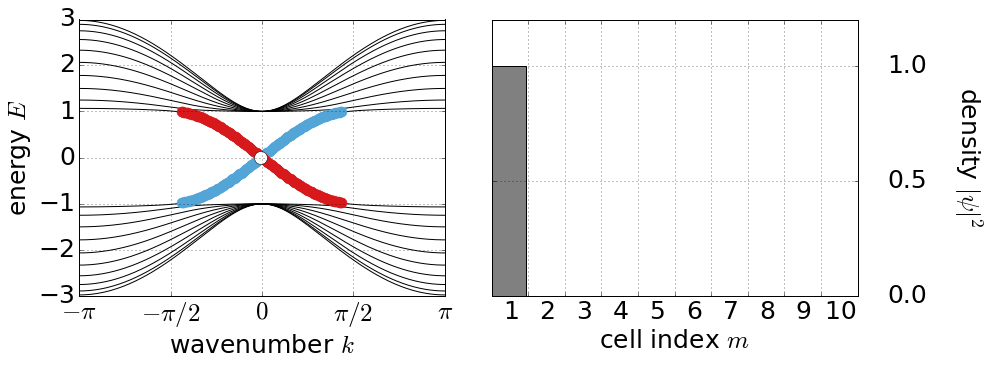

In [8]:
figsize(14,5)
interact(QWZribb.plotenpsi,ki=(0,len(QWZribb.kran)-1),n=(0,QWZribb.L*QWZribb.idf-1));

## Finite sample - the potato argument

Finally we define a finite rectangular shaped lattice and than cut out a potato shaped region out of it and inspect the spectrum and the wavefunctions of this finite irregular sample.

In [9]:
class finite_lattice:
    '''
    Class for a generic 2D lattice.
    '''
    def __init__(self,xL=4,yL=3,**kwargs):
        '''
        Initializatin
        '''

        self.xL=xL
        self.yL=yL
        self.xran=arange(xL)
        self.yran=arange(yL)
        self.ym,self.xm=meshgrid(self.yran,self.xran)
        self.y,self.x=(self.ym.flatten(),self.xm.flatten())

    def make_ham(self,Tx,Ty,U,**kwargs):
        '''
        Make Hamiltonian for a square shape
        '''
        ODX=ssp.diags([ones(self.xL-1)],[1])
        DX =ssp.diags([ones(self.xL)],[0])
        ODY=ssp.diags([ones(self.yL-1)],[1])
        DY =ssp.diags([ones(self.yL)],[0])
        # internal degrees of freedom
        self.idf=shape(Tx)[0]   
        self.H=(ssp.kron(DX,ssp.kron(ODY,Ty))+
                ssp.kron(DX,ssp.kron(ODY,Ty)).H +
                ssp.kron(ODX,ssp.kron(DY,Tx))+
                ssp.kron(ODX,ssp.kron(DY,Tx)).H +
                ssp.kron(DX,ssp.kron(DY,U)) )
        
    def plot_fullwf(self,psi,**kwargs):
        '''
        Plotter for wavefunctions of the whole lattice.
        '''
        pcolor(self.xm,self.ym,
               reshape(sum(
                    reshape(abs(psi)**2,(self.xL*self.yL,self.idf)),
                    axis=1),(self.xL,self.yL)
                      ),**kwargs)

        
    def cut_potato(self,potx,poty,inverted=False,**kwargs):
        '''
        Make Hamiltonian for an arbitrary shape.
        We carve out the shape from the rectangle
        of the original lattice.
        '''
        potato=matplotlib.path.Path(array([potx,poty]).T)        
        self.potato_cindx=(potato.contains_points(
                           array([self.x,self.y]).T))
        self.potato_hindx=(potato.contains_points(
                           array([kron(self.x,ones(self.idf)),
                                  kron(self.y,ones(self.idf))]).T))
        if inverted:
            self.potato_cindx=logical_not(self.potato_cindx)
            self.potato_hindx=logical_not(self.potato_hindx)
        self.Hpotato=self.H[:,self.potato_hindx][self.potato_hindx,:]

Now we generate the rectangule shape

In [17]:
QWZ=finite_lattice(xL=160,yL=100)
QWZ.make_ham(t_x,t_y,-1.85*u)

The two commented codeblocks below calculate the spectrum and vizualize the wavefunction of the rectangle.

In [18]:
#va,ve=sla.eigsh(QWZ.H,100,sigma=0.02)

In [19]:
#figsize(10,5)
#@interact(i=(0,len(va)-1))
#def play(i=0):
#    subplot(121)
#    plot(arange(len(va)),sort(va),'r+')
#    plot(arange(len(va))[i],va[argsort(va)][i],'wo',ms=10)
#    subplot(122,aspect='equal')
#    QWZ.plot_fullwf(ve[:,argsort(va)[i]],cmap='magma')
#    axis('off');

Now we define cutting and calculate the spectrum of the "potato".

In [20]:
th=linspace(0,2*pi,100)
krx,kry=(60*(cos(th)+0.1*cos(3*th-0.3))+80,40*(sin(th)-0.1*sin(6*th+0.5))+50)
QWZ.cut_potato(krx,kry)
Vdis=ssp.diags(kron(randn(int(QWZ.Hpotato.shape[0]/QWZ.idf)),ones(QWZ.idf)),0)

In [21]:
vap,vep=sla.eigsh(QWZ.Hpotato+0.01*Vdis,100,sigma=0.01)
vep=vep[:,argsort(vap)]
vap=sort(vap)
dummy=zeros((QWZ.H.shape[0],len(vap)),dtype=complex)
dummy[QWZ.potato_hindx,:]=vep

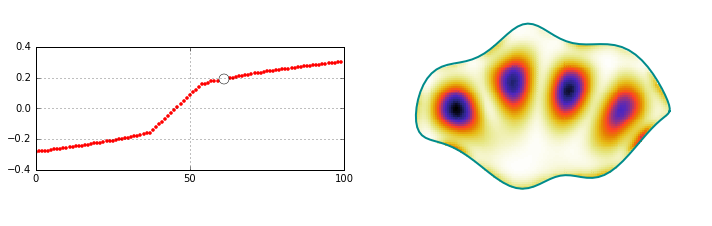

In [22]:
figsize(10,7)
@interact(i=(0,len(vap)-1))
def play(i=40):
    subplot(121,aspect=50)
    plot(arange(len(vap)),vap,'r.')
    plot(arange(len(vap))[i],vap[i],'wo',ms=10)
    ylim(-0.4,0.4)
    yticks(linspace(-0.4,0.4,5))
    xticks(linspace(0,len(vap),3))
    grid()
    subplot(122,aspect='equal')
    QWZ.plot_fullwf(dummy[:,i],cmap='CMRmap_r')
    plot(krx+0.5,kry+0.5,'-',color='darkcyan',lw=2)
    axis('off');
    tight_layout()